# PaperTalks-Research Review Podcast
This notebook converts research papers into engaging podcast-style conversations, where AI agents take on the roles of the paper’s author and a reviewer to explain, critique, and discuss the findings.

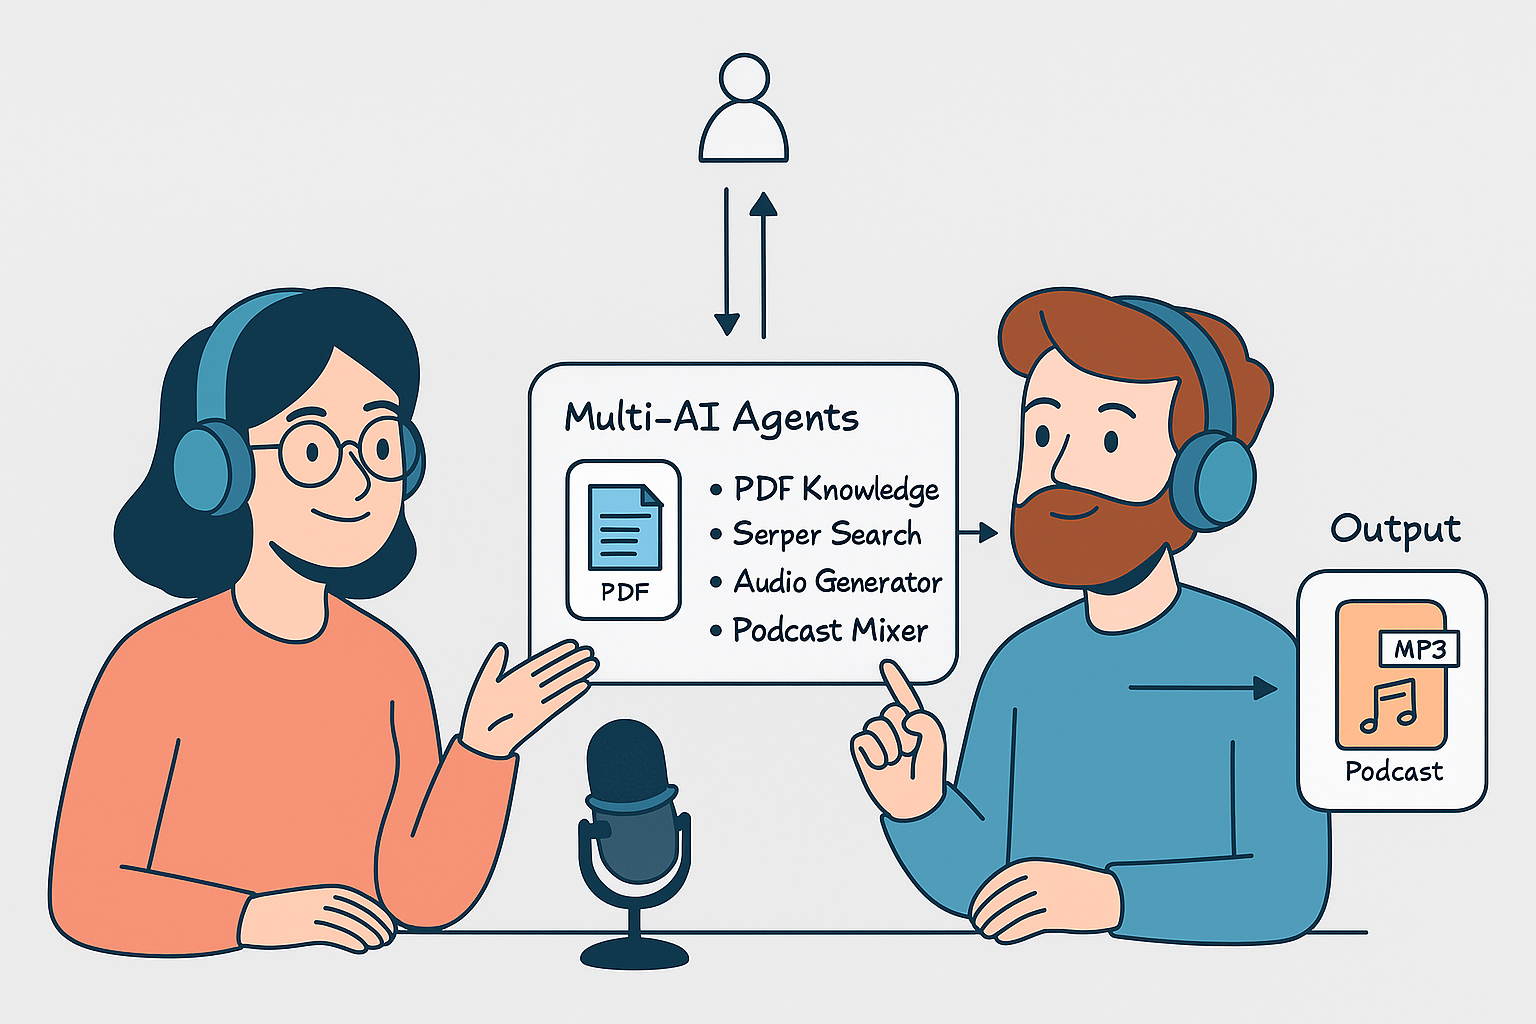


# Setup

In [ ]:
%pip install --quiet crewai crewai-tools elevenlabs python-dotenv pydub pydantic

# Environment Variables

In [ ]:
import os
from google.colab import userdata

# Set your API keys here
os.environ['AIML_API_KEY'] = userdata.get('AIML_API_KEY')
os.environ['ELEVENLABS_API_KEY'] = userdata.get('ELEVENLABS_API_KEY')
os.environ['SERPER_API_KEY'] = userdata.get('SERPER_API_KEY')

# Voice IDs from ElevenLabs
os.environ['BEN_VOICE_ID'] = userdata.get('BEN_VOICE_ID')
os.environ['CLAUDIA_VOICE_ID'] = userdata.get('CLAUDIA_VOICE_ID')

# Tools for Agents to use

In [ ]:
import os
from typing import Dict, List, Optional, Any, Type
from datetime import datetime
from pydub import AudioSegment
from crewai.tools import BaseTool
from pydantic import Field, BaseModel, ConfigDict
from elevenlabs.client import ElevenLabs

In [ ]:
class VoiceConfig(BaseModel):
    """Voice configuration settings."""
    stability: float = 0.45  # Slightly lower for more natural variation
    similarity_boost: float = 0.85  # Higher to maintain consistent voice character
    style: float = 0.65  # Balanced expressiveness
    use_speaker_boost: bool = True
    model_id: str = "eleven_multilingual_v2"
    output_format: str = "mp3_44100_128"
    apply_text_normalization: str = "auto"  # 'auto', 'on', or 'off'

class AudioConfig(BaseModel):
    """Audio processing configuration."""
    format: str = "mp3"
    sample_rate: int = 48000  # Higher for better quality
    channels: int = 2
    bitrate: str = "256k"     # Higher bitrate for clearer audio
    normalize: bool = True    # Normalize audio levels
    target_loudness: float = -14.0  # Standard podcast loudness (LUFS)
    compression_ratio: float = 2.0   # Light compression for voice

class Dialogue(BaseModel):
    """Dialogue for the podcast audio generation tool."""
    speaker: str
    text: str

class PodcastAudioGeneratorInput(BaseModel):
    """Input for the podcast audio generation tool."""
    dialogue: List[Dialogue]

In [ ]:
class PodcastAudioGenerator(BaseTool):
    """Enhanced podcast audio generation tool."""

    name: str = "PodcastAudioGenerator"
    description: str = "Synthesizes podcast voices using ElevenLabs API."

    model_config = ConfigDict(arbitrary_types_allowed=True)

    api_key: str = Field(default_factory=lambda: os.getenv("ELEVENLABS_API_KEY"))
    voice_configs: Dict[str, Dict] = Field(default_factory=dict)
    audio_config: AudioConfig = Field(default_factory=AudioConfig)
    output_dir: str = Field(default="output/audio-files")
    client: Any = Field(default=None)
    args_schema: Type[BaseModel] = PodcastAudioGeneratorInput

    def __init__(self, **data):
        super().__init__(**data)
        if not self.api_key:
            raise ValueError("ELEVENLABS_API_KEY environment variable not set")
        self.client = ElevenLabs(api_key=self.api_key)

    def add_voice(self, name: str, voice_id: str, config: Optional[VoiceConfig] = None) -> None:
        """Add a voice configuration."""
        self.voice_configs[name] = {
            "voice_id": voice_id,
            "config": config or VoiceConfig()
        }

    def _run(self, dialogue: List[Dialogue]) -> List[str]:
        """Generate audio files for each script segment."""
        os.makedirs(self.output_dir, exist_ok=True)

        audio_files = []
        for index, segment in enumerate(dialogue):
            speaker = segment.get('speaker', '').strip()
            text = segment.get('text', '').strip()

            if not speaker or not text:
                print(f"Skipping segment {index}: missing speaker or text")
                continue

            voice_config = self.voice_configs.get(speaker)
            if not voice_config:
                print(f"Skipping unknown speaker: {speaker}")
                continue

            try:
                audio_generator = self.client.text_to_speech.convert(
                    text=text,
                    voice_id=voice_config["voice_id"],
                    model_id=voice_config['config'].model_id,
                    output_format=voice_config['config'].output_format,
                    voice_settings={
                        "stability": voice_config['config'].stability,
                        "similarity_boost": voice_config['config'].similarity_boost,
                        "style": voice_config['config'].style,
                        "use_speaker_boost": voice_config['config'].use_speaker_boost
                    }
                )

                # Convert generator to bytes
                audio_bytes = b''.join(chunk for chunk in audio_generator)

                filename = f"{self.output_dir}/{index:03d}_{speaker}.{self.audio_config.format}"
                with open(filename, "wb") as out:
                    out.write(audio_bytes)

                # Basic audio normalization
                if self.audio_config.normalize:
                    audio = AudioSegment.from_file(filename)
                    normalized = audio.normalize()  # Simple normalization
                    normalized = normalized + 4  # Slight boost

                    # Use context manager to ensure file is closed
                    with normalized.export(
                        filename,
                        format=self.audio_config.format,
                        bitrate=self.audio_config.bitrate,
                        parameters=["-ar", str(self.audio_config.sample_rate)]
                    ) as f:
                        f.close()

                audio_files.append(filename)
                print(f'Audio content written to file "{filename}"')

            except Exception as e:
                print(f"Error processing segment {index}: {str(e)}")
                continue

        return sorted(audio_files)

In [ ]:
class PodcastMixer(BaseTool):
    """Enhanced audio mixing tool for podcast production."""

    name: str = "PodcastMixer"
    description: str = "Mixes multiple audio files with effects into final podcast."

    audio_config: AudioConfig = Field(default_factory=AudioConfig)
    output_dir: str = Field(default="output/podcast")

    def _run(
        self,
        audio_files: List[str],
        crossfade: int = 50
    ) -> str:
        if not audio_files:
            raise ValueError("No audio files provided to mix")

        try:
            # Create output directory if it doesn't exist
            os.makedirs(self.output_dir, exist_ok=True)

            mixed = AudioSegment.from_file(audio_files[0])
            for audio_file in audio_files[1:]:
                next_segment = AudioSegment.from_file(audio_file)
                # Add silence and use crossfade
                silence = AudioSegment.silent(duration=200)
                next_segment = silence + next_segment
                mixed = mixed.append(next_segment, crossfade=crossfade)

            # Simplified output path handling
            output_file = os.path.join(self.output_dir, "podcast_final.mp3")

            mixed.export(
                output_file,
                format="mp3",
                parameters=[
                    "-q:a", "0",  # Highest quality
                    "-ar", "48000"  # Professional sample rate
                ]
            )

            print(f"Successfully mixed podcast to: {output_file}")
            return output_file

        except Exception as e:
            print(f"Error mixing podcast: {str(e)}")
            return ""

# Output Directory Structure

In [ ]:
def setup_directories():
    """Set up organized directory structure"""
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    dirs = {
        'BASE': f'outputs/{timestamp}',
        'SEGMENTS': f'outputs/{timestamp}/segments',
        'FINAL': f'outputs/{timestamp}/podcast',
        'DATA': f'outputs/{timestamp}/data'
    }

    for directory in dirs.values():
        os.makedirs(directory, exist_ok=True)

    return dirs

# Upload PDF

In [ ]:
import os
import shutil
from google.colab import files

# Create the 'knowledge' folder if it doesn't exist
if not os.path.exists('knowledge'):
    os.makedirs('knowledge')

# Upload the PDF file
uploaded = files.upload()
pdf_filename = list(uploaded.keys())[0]

# Move the uploaded file to the 'knowledge' folder
shutil.move(pdf_filename, os.path.join('knowledge', pdf_filename))

# Setup Agents & Tasks

In [ ]:
from crewai import Agent, Task, Crew, Process, LLM
from crewai.knowledge.source.pdf_knowledge_source import PDFKnowledgeSource
from crewai_tools import SerperDevTool
from pydantic import BaseModel, Field
from typing import List
from datetime import datetime

In [ ]:
# Pass only the filename to PDFKnowledgeSource
research_paper = PDFKnowledgeSource(file_paths=pdf_filename)

In [ ]:
# --- Pydantic Model definitions ---
class PaperSummary(BaseModel):
    """Summary of a research paper."""
    title: str = Field(..., description="Title of the research paper")
    main_findings: List[str] = Field(..., description="Key findings as a list of strings")
    methodology: str = Field(..., description="Research methodology as a single text block")
    key_implications: List[str] = Field(..., description="Implications as a list of strings")
    limitations: List[str] = Field(..., description="Limitations as a list of strings")
    future_work: List[str] = Field(..., description="Future research directions as a list")
    summary_date: datetime = Field(..., description="Timestamp of summary creation")

class DialogueLine(BaseModel):
    """Dialogue line for a podcast script."""
    speaker: str = Field(..., description="Name of the speaker (Julia or Guido)")
    text: str = Field(..., description="The actual dialogue line")

class PodcastScript(BaseModel):
    """Podcast script with dialogue lines."""
    dialogue: List[DialogueLine] = Field(..., description="Ordered list of dialogue lines")

class AudioGeneration(BaseModel):
    """Audio generation result with metadata."""
    segment_files: List[str] = Field(..., description="List of generated audio segment files")
    final_podcast: str = Field(..., description="Path to the final mixed podcast file")

In [ ]:
# --- LLM Setup ---
summary_llm = LLM(
    model="openai/o3-mini",
    base_url="https://api.aimlapi.com/v1",
    api_key=os.getenv("AIML_API_KEY")
)

script_llm = LLM(
    model="openai/o1",
    base_url="https://api.aimlapi.com/v1",
    api_key=os.getenv("AIML_API_KEY")

)

script_enhancer_llm = LLM(
    model="openai/o3-mini",
    base_url="https://api.aimlapi.com/v1",
    api_key=os.getenv("AIML_API_KEY")

)

audio_llm = LLM(
    model="openai/gpt-4o-mini",
    base_url="https://api.aimlapi.com/v1",
    api_key=os.getenv("AIML_API_KEY")

)

# Setup ElevenLabs Voices

In [ ]:
# Create and configure tools
dirs = setup_directories()
audio_generator = PodcastAudioGenerator(output_dir=dirs['SEGMENTS'])

# Julia: Enthusiastic expert
audio_generator.add_voice(
    "Julia",
    os.getenv("CLAUDIA_VOICE_ID"),
    VoiceConfig(
        stability=0.35,  # More variation for natural enthusiasm
        similarity_boost=0.75,  # Maintain voice consistency
        style=0.65,  # Good expressiveness without being over the top
        use_speaker_boost=True
    )
)

# Guido: Engaged and curious
audio_generator.add_voice(
    "Guido",
    os.getenv("BEN_VOICE_ID"),
    VoiceConfig(
        stability=0.4,  # Slightly more stable but still natural
        similarity_boost=0.75,
        style=0.6,  # Balanced expressiveness
        use_speaker_boost=True
    )
)

podcast_mixer = PodcastMixer(output_dir=dirs['FINAL'])
search_tool = SerperDevTool()

# Agents

In [ ]:
# --- Agents ---
researcher = Agent(
    role="Research Analyst",
    goal="Create comprehensive yet accessible research paper summaries",
    backstory="""You're a PhD researcher with a talent for breaking down complex
    academic papers into clear, understandable summaries. You excel at identifying
    key findings and their real-world implications.""",
    verbose=True,
    llm=summary_llm
)

research_support = Agent(
    role="Research Support Specialist",
    goal="Find current context and supporting materials relevant to the paper's topic",
    backstory="""You're a versatile research assistant who excels at finding
    supplementary information across academic fields. You have a talent for
    connecting academic research with real-world applications, current events,
    and practical examples, regardless of the field. You know how to find
    credible sources and relevant discussions across various domains.""",
    verbose=True,
    tools=[search_tool],
    llm=script_llm
)

script_writer = Agent(
    role="Podcast Script Writer",
    goal="Create engaging and constructive podcast scripts that simulate an author–reviewer discussion about a research paper",
    backstory="""You're a skilled podcast writer who specializes in turning technical
    paper reviews into insightful and natural conversations. You create dialogue
    between two people:
    - Julia: The researcher who wrote the paper, explaining their methods and findings.
    - Guido: The thoughtful reviewer who critically engages with the work,
      asking probing questions, highlighting limitations, and offering constructive improvements.
    Your job is to make this exchange both informative and conversational—something
    listeners can learn from while enjoying the dynamic interplay of critique and defense.""",
    verbose=True,
    llm=script_llm
)


script_enhancer = Agent(
    role="Podcast Script Enhancer",
    goal="Enhance podcast scripts to be more engaging while maintaining educational value",
    backstory="""You're a veteran podcast producer who specializes in making technical
    content both entertaining and informative. You excel at adding natural humor,
    relatable analogies, and engaging banter while ensuring the core technical content
    remains accurate and valuable. You've worked on shows like Lex Fridman's podcast,
    Hardcore History, and the Joe Rogan Experience, bringing their signature blend of
    entertainment and education.""",
    verbose=True,
    llm=script_enhancer_llm
)

audio_generator_agent = Agent(
    role="Audio Generation Specialist",
    goal="Generate high-quality podcast audio with natural-sounding voices",
    backstory="""You are an expert in audio generation and processing. You understand
    how to generate natural-sounding voices and create professional podcast audio. You
    consider pacing, tone, and audio quality in your productions.""",
    verbose=True,
    allow_delegation=False,
    tools=[audio_generator, podcast_mixer],
    llm=audio_llm
)

# Tasks

In [ ]:
# --- Tasks ---
summary_task = Task(
    description="""Hey there, researcher! Your mission is to dive into the
    research paper provided in {paper} and uncover its core insights.
    As you create the summary, please:

    - Highlight the Big Ideas: What are the main findings and conclusions?
    - Explain the Method: Break down the study’s methodology in everyday language.
    - Discuss the Impact: What are the key implications for the field?
    - Note the Caveats: Mention any limitations or uncertainties.
    - Look Ahead: Offer some thoughts on future research directions.

    Keep your tone engaging and friendly so that an educated general audience can
    easily follow along while staying true to the technical details.""",
    expected_output="A clear, well-structured summary that covers all the critical aspects of the paper in an accessible and engaging manner.",
    agent=researcher,
    output_pydantic=PaperSummary,
    output_file="output/metadata/paper_summary.json"
)

supporting_research_task = Task(
    description="""Alright, now that we have the paper summary, let’s add some
    real-world flavor. Your task is to gather recent and credible supporting
    materials that enrich the topic. Here’s how to proceed:

    - Spot the Themes: Identify the main ideas from the paper and see how they connect with broader trends.
    - Current Developments: Find news, advancements, or case studies from the
    last couple of years that bring these ideas to life.
    - Explore Diverse Views: Look for expert opinions, debates, and alternative perspectives.
    - Real-World Examples: Gather examples from industry reports, white papers, or professional discussions.

    Your goal is to build a collection of supporting insights that help listeners
    understand how the research plays out in real life. Make sure your sources
    are recent, reliable, and add that extra context.""",
    expected_output="A curated collection of supporting materials and real-world examples that add context and depth to the research paper’s topic.",
    agent=research_support,
    context=[summary_task],
    output_file="output/metadata/supporting_research.json"
)

podcast_task = Task(
    description="""Using the paper summary and supporting research, craft a podcast-style
    conversation between Julia (the researcher) and Guido (the critical but
    constructive peer). The exchange should feel natural and conversational while
    reflecting the dynamics of academic discussion.

    Guidelines:

    Keep the Tone Academic Yet Accessible:
    - Allow the Author to explain their motivations, methods, and findings clearly,
      without being overly formal.
    - Have the Reviewer ask challenging but respectful questions, probing the
      assumptions, limitations, and potential improvements.

    Clearly Distinguish Perspectives:
    - Julia should use phrases like "In our study, we found…" or "Our approach was…"
    - Guido should use phrases like "Have you considered…" or "One limitation I see is…"

    Embrace Natural Dialogue:
    - Include interruptions, clarifications, and back-and-forth exchanges like in
      real academic discussions.
    - Use natural conversational markers such as "That’s a good point," "I see," or
      "Let me push back on that…"

    Balance Critique with Collaboration:
    - Reviewer should not only challenge but also suggest constructive directions
      or acknowledge strengths.
    - Author should occasionally defend their approach but also recognize areas
      for improvement.

    Example Flow:
    Julia: "In our study, we aimed to improve document layout understanding with AI."
    Guido: "That’s interesting. But how does your method handle noisy scans?"
    Julia: "Good question. We actually incorporated a preprocessing step to address that."
    Guido: "I like that. Though I wonder if integrating multimodal signals might strengthen the model further…"

    Your script should clearly separate the Author’s explanations from the Reviewer’s
    critiques and suggestions, while keeping it lively and engaging for listeners.""",
    expected_output="A lively and natural podcast script simulating a constructive discussion between a paper’s author and reviewer, blending clear explanations with probing critiques.",
    agent=script_writer,
    context=[summary_task, supporting_research_task],
    output_pydantic=PodcastScript,
    output_file="output/metadata/podcast_script.json"
)

enhance_script_task = Task(
    description="""Now, take the initial author–reviewer script and refine it so
    that it feels like a genuine academic yet conversational dialogue.

    - Infuse Realism: Add natural markers like "That’s interesting," "I see,"
      or "Let me clarify that…" to mimic real back-and-forth.
    - Smooth the Flow: Ensure transitions between critique and response feel
      like a genuine conversation, not a rigid Q&A.
    - Keep Roles Distinct: Author should defend, clarify, or acknowledge limitations.
      Reviewer should probe, critique, and suggest improvements.
    - Preserve Accuracy: Maintain correctness of technical details and paper content.
    - Encourage Constructive Tone: Even when critical, the Reviewer should balance
      with constructive advice.

    Important:
    - Do not rename or replace the roles (Julia, Guido).
    - Avoid stage directions (e.g., *laughs*); let tone come through in words.

    Your enhanced script should sound like you’re listening to an actual peer-review
    exchange—thoughtful, occasionally sharp, but ultimately collaborative and enlightening.""",
    expected_output="An enhanced podcast script that realistically simulates an author–reviewer exchange, engaging and educational while maintaining technical accuracy.",
    agent=script_enhancer,
    context=[summary_task, podcast_task],
    output_pydantic=PodcastScript,
    output_file="output/metadata/enhanced_podcast_script.json",
    human_input=True
)


audio_task = Task(
    description="""Generate high-quality audio for the podcast script and create the final podcast.

    The script will be provided in the context as a list of dialogue entries, each with:
    - speaker: Either "Julia" or "Guido"
    - text: The line to be spoken

    Process:
    1. Generate natural-sounding audio for each line of dialogue using appropriate voices
    2. Apply audio processing for professional quality:
       - Normalize audio levels
       - Add subtle fade effects between segments
       - Apply appropriate pacing and pauses
    3. Mix all segments into a cohesive final podcast

    Voice Assignments:
    - For Julia's lines: Use configured Julia voice
    - For Guido's lines: Use configured Guido voice

    Quality Guidelines:
    - Ensure consistent audio levels across all segments
    - Maintain natural pacing and flow
    - Create smooth transitions between speakers
    - Verify audio clarity and quality""",
    expected_output="A professional-quality podcast audio file with natural-sounding voices and smooth transitions",
    agent=audio_generator_agent,
    context=[enhance_script_task],
    output_pydantic=AudioGeneration,
    output_file="output/metadata/audio_generation_meta.json"
)

# Crew

In [ ]:
# --- Crew and Process ---
crew = Crew(
    agents=[researcher, research_support, script_writer, script_enhancer, audio_generator_agent],
    tasks=[summary_task, supporting_research_task, podcast_task, enhance_script_task, audio_task],
    process=Process.sequential,
    knowledge_sources=[research_paper],
    embedder={
        "provider": "openai",
        "config": {
            "model": "text-embedding-3-small",
            "api_key": os.getenv("AIML_API_KEY"),
            "api_base": "https://api.aimlapi.com/v1"
        }
    },
    verbose=True,
    memory=False
)

# Run

In [ ]:
if __name__ == "__main__":
    # Update task output files
    summary_task.output_file = os.path.join(dirs['DATA'], "paper_summary.json")
    supporting_research_task.output_file = os.path.join(dirs['DATA'], "supporting_research.json")
    podcast_task.output_file = os.path.join(dirs['DATA'], "podcast_script.json")
    enhance_script_task.output_file = os.path.join(dirs['DATA'], "enhanced_podcast_script.json")
    audio_task.output_file = os.path.join(dirs['DATA'], "audio_generation_meta.json")

    # Run the podcast generation process
    results = crew.kickoff()